# Red Black Graph - a DAG of Multiple, Interleaved Binary Trees

## Introduction

When attempting to represent relationships such as human familial relationships one of several common approaches are generally utilized including ad-hoc, general graphs, specialized tables or charts. Graphs are typically the most mathematically rigourous approach taken to calculate properties such as diameter, betweeness, etc. As we've explored efficient representations we've come to realize that a specialized graph representation, which we've named a Red Black Graph, has some interesting properties and shows promise in efficiently tackling some of problems in the field including relationship calculation, loop detection/prevention, etc.

The name, Red Black Graph, comes from a similar concept of Red Black Trees. Red Black Trees are binary trees such that each node has an extra bit, color (red or black). This color bit us used to balance the tree as modifications are made. We find that representing familial relationships as multiple interleaved binary trees an effective approach. Adding a color bit to each vertex helps constrain and simplify the representation and gives rise to some interesting emrgent properties. In this paper, we'll provide a formal definition of a Red-Black graph, the underlying mathematics as well as illustrate several applications and benefits in using this to model familial relationships.

## Formal Definition

A Red Black Graph is a DAG with the following constraints:

1. Any given vertex must have a color, either red or black
2. Any given vertex can have at most one outbound edge to another vertex of each color

## Motivation

The relationships resulting from sexual reproduction can be modeled by a Red Black Graph, arbitrarily assigning vertices that are male as Red and vertices that are female as Black. 



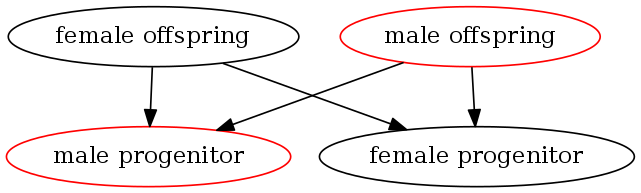

In [1]:
import networkx as nx
from nxpd import draw
G = nx.DiGraph()
G.graph['dpi'] = 120
G.add_node('male progenitor', color='red')
G.add_node('female progenitor', color='black')
G.add_node('female offspring', color='black')
G.add_node('male offspring', color='red')
G.add_edge('male offspring', 'male progenitor')
G.add_edge('male offspring', 'female progenitor')
G.add_edge('female offspring', 'male progenitor')
G.add_edge('female offspring', 'female progenitor')
draw(G, show='ipynb')

Directionality is significant. Edges are drawn from the offspring to the parent to ensure the second constraint is observed.  

For a given vertex in a Red Black graph there are two distinct sub-graphs or "views" or perspectives. 

* Ancestry - For a given vertex if we consider the subset of the Red Black graph that consists of that vertex and all vertices reachable by following out-bound edges, we see this subset is a proper binary tree. We'll designate this as the ancestry view.
* Descendency - For a given vertex if we consider the subset of the Red Black graph that consists of that vertex and all vertices that can follow a traversal through the graph that reach that vertex, we see a DAG. We'll designate this as the descendency view.

## Adjacency Matrix

In graph theory an adjacency matrix is a square matrix used to represent the graph. The elements of the matrix are 1 if there is an edge between the vertices represented by the column index and the row index. Slightly more formally, with a graph of vertex set *V*, the adjacency matrix is a square |*V*| x |*V*| matrix, *A*, such that $A_{ij}$ is one when there is an edge from $vertex_{i}$ to $vertex_{j}$ and zero otherwise.

The example graph above would be represented by the following adjacency matrix.

$$\begin{bmatrix}
0 & 0 & 1 & 1 \\
0 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}$$

### Red-Black Graph Adjacency Matrix

We define the Red-Black adjacency matrix as follows: 
* elements are 2 if there is an edge between any vertex and a red vertex
* elements are 3 if there is an edge between any vertex and a black vertex 
* diagonal elements are -1 if the vertex is red
* diagonal elements are 1 if the vertex is black 

Slightly more formally, with a graph of vertex set *V*, where a vertex may be colored either *Red* or *Black*, the Red-Black adjacency matrix is a square |*V*| x |*V*| matrix, *A<sub>rb</sub>*, such that *A<sub>rb<sub>ij</sub></sub>* is:
* -1 if *i* == *j* and $vertex_{i}$ is *Red*
* 1 if *i* == *j* and $vertex_{i}$ is *Black*
* 2 if there is an edge from $vertex_{i}$ to $vertex_{j}$ and $vertex_{j}$ is *Red*
* 3 if there is an edge from $vertex_{i}$ to $vertex_{j}$ and $vertex_{j}$ is *Black*
* 0 otherwise

With this definition, the example graph above would be represented by the following Red-Black adjacency matrix. 

$$\begin{bmatrix}
1 & 0 & 2 & 3 \\
0 & -1 & 2 & 3 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$$

### Observations

We note the following properties (obviously self-evident):

$$trace(A_{rb}) = |V_{black}| - |V_{red}|$$

$$|V| = |V_{black}| + |V_{red}|$$

$$|V_{black}| = \frac{|V| + trace(A_{rb})}{2}$$

## Transitive Closure of a Red-Black Adjacency Matrix

Transitive closure for an adjacency matrix, $A$, results in a matrix, $A^+$ that shows all vertices that are reachable from any given vertex. We examine the correlary, given a Red Black adjacency matrix, $A_{rb}$, by computing the transitive closure, $A_{rb}^+$, that results not only in reachability, but explicit information about how one vertex is reachable from another, including number of edges required to traverse as well as the explicit traversal path. 

Before examining the transitive closure, we'll explore a few basis concepts first:

* Pedigree Numbers
* Generation function
* Traversal path
* Transitive Relationship funciton

### Pedigree Numbers, Generation Function and Traversal Path

In recording ancestral relationships it is common to use a pedigree chart to record the ancestry for a given person. 

<img src="img/pedigree-1.png" alt="Drawing" style="width: 600px;"/>

Note that in the above pedigree chart, the father's position is labeled "2", the mothers's "3", the paternal grandfather's "4", etc. We will refer to this labeling of the binary tree as the "pedigree number". 

#### Observations

In the pedigree chart:

* All male (red) vertices are labeled with an even number; all female (black) vertices are labeled with an odd number
* The generation function for a given pedigree number is defined as the number of edges that must be followed to connect the root vertex (position 1 in the above chart) with a vertex designated by the pedigree number. The generation function is trivially derived by taking the integral portion of $log_{2}$ of the vertex label. (Another way of expressing this is: if the pedigree number is represented in binary form, the generation is the positional value of the left most significant bit.)
* The traversal path from the root vertex to a given vertex can be derived from the pedigree number by successively right shifting out bits and using that bit to "walk" the traversal edge to a red vertex or black vertex.

A simple implementation of the *generation* and *traversal* functions follow:

In [4]:
# %load ../redblackgraph/simple/generation.py
def generation(pedigree_number):
    '''Given a pedigree_number, representing a relationship from a "root" vertex to an "ancester" vertex,
    return the number of edges that must be followed in order to "walk" from the "root" to the "ancester".'''
    x = pedigree_number
    gen = 0
    while (x > 1):
        x >>= 1
        gen += 1
    return gen


def get_traversal_path(pedigree_number):
    '''Given a pedigree_number, representing a relationship from a "root" vertex to an "ancester" vertex,
    return the traversal path of edges to red or black vertices to "walk" from the "root" to the "ancesster".

    For example, input of 14 results in ['b', 'b', 'r'] which indicates that starting at the "root" vertex, follow
    the edge to the black vertex, then the edge to the black vertex then the edge to the red vertex.'''
    x = pedigree_number
    path = []
    mask = 1
    while (x > 1):
        path.insert(0, 'b' if x & mask else 'r')
        x >>= 1
    return path


Consider the traversal path for *my* maternal grandfather's mother (pedigree number 13)

In [5]:
get_traversal_path(13)

['b', 'r', 'b']

This results in the graph walk starting at *my* node of following the arc to the black vertex, from there to the red vertex, from their to the black vertex and arriving at *my* maternal grandfather's mother.

### Transitive Relationship Function

Consider the following case of 3 vertices: $vertex_{a}$, $vertex_{b}$ and $vertex_{c}$. Further, let's assume that $vertex_{b}$ is related to $vertex_{a}$ as defined by *pedigree_number* **x**, and that $vertex_{c}$ is related to $vertex_{b}$ by *pedigree_number* **y**. Therefor $vertex_{c}$ is related to $vertex_{a}$ by some *pedigree_number* **z**. We define the transitive realtionship function (designated as *avos*) as:  **z** = **x** *avos* **y**. (*avos* is latin for ancestor.)

Consider this concrete example: $vertex_{a}$ may be any person; $vertex_{b}$ is that person's paternal grandfather (pedigree_number == 4); $vertex_{c}$ is $vertex_{b}$'s maternal grandmother (pedigree_number == 7). If we were to transcribe $vertex_{b}$'s pedigree into the proper place in $vertex_{a}$'s pedigree chart we'd see that $vertex_{c}$ has a pedigree_number of 19 in $vertex_{a}$'s pedigree. In other words, **19** = **4** *avos* **7**.

In order to uncover the arithmetic for this operator, let's look at the *pedigree numbers* for a few examples. In all cases, we'll assume that **I** am the person represented by $vertex_{a}$. The first column describes **my** relationship to $vertex_{b}$, the second column describes $vertex_{b}$'s relationship to $vertex_{c}$, the third column is the *pedigree number* that represents **my** relationship to $vertex_{b}$ \[pn(me, b)\], the forth column is the *pedigree number* that represents $vertex_{b}$'s relationship to $vertex_{c}$ \[pn(b, c)\], the final column is the *pedigree number* that represents **my** relationship to $vertex_{c}$ \[pn(me, c)\].

| b's relationship to me | c's relationship to b | pn(me, b) | pn(b, c) | pn(me, c) |
| ---------------------- | --------------------- | --------- | -------- | --------- |
| father                 | father                | 2         | 2        | 4         |
| father                 | mother                | 2         | 3        | 5         |
| mother                 | father                | 3         | 2        | 6         |
| mother                 | mother                | 3         | 3        | 7         |
| father                 | paternal grandfather  | 2         | 4        | 8         |
| maternal grandmother   | paternal grandfather  | 7         | 4        | 28        |

While there appears to be some sort of "counting" going on, it isn't obvious what aritmetic is used to arrive at the correct result.

Let's look at the same information, but recast the numbers into $base_{2}$.

| b's relationship to me | c's relationship to b | pn(me, b) | pn(b, c) | pn(me, c) |
| ---------------------- | --------------------- | --------- | -------- | --------- |
| father                 | father                | 10        | 10       | 100       |
| father                 | mother                | 10        | 11       | 101       |
| mother                 | father                | 11        | 10       | 110       |
| mother                 | mother                | 11        | 11       | 111       |
| father                 | paternal grandfather  | 10        | 100      | 1000      |
| maternal grandmother   | paternal grandfather  | 111       | 100      | 11100     |

While perhaps not obvious, upon examination of the binary representation, we see that the *avos* function simply replaces the left most significant digit of pn(b,c)<sub>base2</sub> with the value of pn(me,b)<sub>base2</sub>.

With this observation, a simple implementation of the *avos* function follows:


In [3]:
# %load ../redblackgraph/simple/avos.py
from redblackgraph.simple import generation


def avos(x, y):
    '''The avos product is a transitive relationship operator.
    Given that:
      - vertex a is related to vertex b by x
      - vertex b is related to vertex c by y
    This product should return the value indicating how a is related to c
    '''

    # An interesting case is presented if x or y is 1 or -1. In these cases the avos product
    # represents the situation where a and b are the same vertex or b and c are the same vertex.
    # In a sense, this is the avos identity
    if x <= 1 or y <= 1:
        return 0 if x == 0 or y == 0 else x if y == 1 or y == -1 else y

    generationNumber = generation(y)
    return (y & (2 ** generationNumber - 1)) | (x << generationNumber)


We'll refer to this transitive relationship function as the *avos* product for scalers.

### Transitive Closure for Red-Black Adjacency Matrix

We will define the transitive closure of a Red-Black adjacency matrix, $A_{rb}$ as $A_{rb}^+$ such that element (i, j) is the *pedigree number* that represents the relationship between $vertex_{i}$ and $vertex_{j}$. Transitive closure of an adjacency matrix can be computed a number of ways, a simple approach is the [Floyd-Warshall Algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm).

Briefly stated, this algorithm is a tripple loop across the matrix indices continously comparing the current distance ($A_{i,j}$) with the distance of the "current" path ($A_{i,k}$ + $A_{k,j}$). In a Red Black Adjacency matrix "distance" is computed via the transitive relationship function. As such, the Floyd-Warshall algorithm can be modified to update a given cell in the adjacency matrix utilizing the *avos* scalar product to compute "distance" rather than summation. Just as in the Floyd-Warshall algorithm, we only update the shortest path if it is less than the current shortest path. In our case, we define a new function nz_min (or non-zero minimum) to return the value of the two operands that is smallest, excluding zero. This effectively serves as a shortest distance check when using the avos scalar product.

In [ ]:
# %load ../redblackgraph/simple/util.py
def nz_min(*args, **kwargs):
    '''
    nz_min(iterable, *[, default=0, key=func]) -> value
    nz_min(arg1, arg2, *args, *[, key=func]) -> value

    With a single iterable argument, return its smallest non-zero item or 0 if iterable is empty. The
    default keyword-only argument specifies an object to return if
    the provided iterable is empty.
    With two or more arguments, return the smallest non-zero argument or 0 of no non-zero values in args.
    '''
    key = kwargs.get("key", lambda x: x)
    default = kwargs.get("default", 0)
    if len(args) == 1:
        args = args[0]
    mini = None
    for i in args:
        k_i = key(i)
        k_mini = key(mini)
        if mini == None or k_mini == 0 or (k_i < k_mini and not k_i == 0):
            mini = i
    return default if mini is None else mini

In [4]:
# %load ../redblackgraph/simple/warshall.py
from redblackgraph.simple import avos, generation, nz_min

def warshall(M):
    '''Computes the transitive closure of a Red Black adjacency matrix and as a side-effect,
    the diameter.'''

    # Modification of stardard warshall algorithm:
    # * Replaces innermost loop's: `W[i][j] = W[i][j] or (W[i][k] and W[k][j])`
    # * Adds diameter calculation
    n = len(M)
    W = M
    diameter = 0
    for k in range(n):
        for i in range(n):
            for j in range(n):
                W[i][j] = nz_min(W[i][j], avos(W[i][k], W[k][j]))
                diameter = max(diameter, W[i][j])
    return W, generation(diameter)

Let's look at the Red-Black adjacency matrix, $A_{rb}$, for the following graph:

* vertex 0 - male offspring of vertex 1 and vertex 2
* vertex 1 - male offspring of vertex 3 and unknown (not in graph)
* vertex 2 - female offspring of unknown (neither in graph)
* vertex 3 - male offspring of unknown (neither in graph)
* vertex 4 - female offspring of vertex 0 and unknown (not in graph)


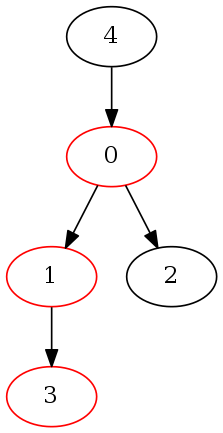

In [5]:
G = nx.DiGraph()
G.graph['dpi'] = 120
G.add_node('0', color='red')
G.add_node('1', color='red')
G.add_node('2', color='black')
G.add_node('3', color='red')
G.add_node('4', color='black')
G.add_edge('0', '1')
G.add_edge('0', '2')
G.add_edge('1', '3')
G.add_edge('4', '0')
draw(G, show='ipynb')


$$\begin{bmatrix}
-1 & 2 & 3 & 0 & 0 \\
0 & -1 & 0 & 2 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 \\
2 & 0 & 0 & 0 & 1 \\
\end{bmatrix}$$

Running this modified Warshall algorithm against this example matrix results in the following $A_{rb}^+$:

$$\begin{bmatrix}
-1 & 2 & 3 & 4 & 0 \\
0 & -1 & 0 & 2 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 \\
2 & 4 & 5 & 8 & 1 \\
\end{bmatrix}$$

Examining the row vector of $A_{rb}^+$ corresponding to $vertex_{4}$, $\begin{bmatrix}2 & 4 & 5 & 8 & 1\end{bmatrix}$, we observe that application of the modified Warshall algorithm resulted in the full ancestry of $vertex_{4}$, $\begin{bmatrix}f & pgf & pgm & pgff & b\end{bmatrix}$. Examining the column vector corresponding to $vertex_{3}$, $\begin{bmatrix}
4 \\
2 \\
0 \\
-1 \\
8 \\
\end{bmatrix}$, resulted in the full descendency for that vertex, $\begin{bmatrix}
pgf \\
f \\
0 \\
r\\
pgff \\
\end{bmatrix}$. (relationship key: r - self (male), b - self (female), f - father, pgf - paternal grandfather, pgm - paternal grandmother, pgff - pathernal grandfather's father)

**TODO**: requires a better explanation of how to read out row vectors and column vectors.

### Observations

Given $A_{rb}^+$, observe that:

* row vectors represent the ancestry view for a given vertex
* column vectors represent descendency view for a given vertex
* row vectors representing siblings will be identical
* column vectors representing siblings will be independant if either of the siblings have offspring represented in the graph
* determining whether *x* is an ancestor of *y* is **O**(1) and provided by $A_{rb}^+$\[x, y\]
* determining whether *x* is a descendant of *y* is **O**(1) and provided by $A_{rb}^+$\[y, x\]
* diameter of the graph is given by generation(max($A_{rb}^+$\[i, j\]))

### Calculating Relationship Between Two Rows in $A_{rb}^+$

Given that row vectors in $A_{rb}^+$ provides the ancestry view for each vertex, we can demonstrate a simple means of calculating relationship, or more specifically, the [consanguinity](https://en.wikipedia.org/wiki/Consanguinity) between vertices. 

1. Given two row vectors from $A_{rb}^+$, *u* and *v*, find the minimum of *u<sub>j</sub>* + v<sub>j</sub>* where both *u<sub>j</sub>* and v<sub>j</sub>* are non-zero. This yields two *pedigree numbers*, x and y, expressing the relationship of *u* and *v* to the nearest common ancestor, *vertex<sub>j-min</sub>*
2. Determine the generational distance to the common ancestor, d<sub>u</sub> = generation(x) and d<sub>v</sub> = generation(y).
3. Using a Table of Consanguinity, calculate the relationship

#### Observation

* determining whether *x* is related to *y* is **O**(*m*) where *m* is the expected number of ancestors and *m* << |*V*| (assuming an efficient sparse matrix representation, otherwise it is **O**(|*V*|))

A simple implementation of calculate_relationship follows:

In [6]:
# %load ../redblackgraph/simple/calc_relationship.py
from redblackgraph.simple import generation


def lookup_relationship(du, dv):
    '''
    This is a very rudimentary implementation of a Consanguinity lookup and doesn't handle many cases
    correctly.
    :param du: generational distance from u to common ancestor
    :param dv: generational distance from v to common ancester
    :return: a string designating relationship
    '''
    removal = abs(du - dv)
    generational = min(du, dv)
    return f"{generational - 1} cousin {removal} removed"


def calculate_relationship(u, v):
    '''
    Determine if a relationship exists between u, v where u, v are row vectors of the transitive closure
    of a Red Black adjacency matrix
    :param u: row vector for vertex u
    :param v: row vector for vertex v
    :return: (Relationship designation, common ancestor vertex)
    '''

    common_ancestor, (x, y) = min([e for e in enumerate(zip(u, v)) if not e[1][0] == 0 and not e[1][1] == 0],
                                  key=lambda x: x[1][0] + x[1][1],
                                  default=(-1, (0, 0)))

    if common_ancestor == -1:
        return "No Relationship", -1
    return lookup_relationship(generation(x), generation(y)), common_ancestor


**TODO**: add some sort of conclusion to this section